In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from scipy.stats import binned_statistic_2d
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from src.pf_stats import *
from src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Load data, only keep complete PFs
pf_stats = load_global_pf_stats()
pf_stats = pf_stats[pf_stats['is_complete']]

# Seperate extreme and non extreme PF stats
expf_id = pf_stats['max_precip']>60
nexpf_id = (10<pf_stats['max_precip']) & (pf_stats['max_precip']<60)
expf_stats = pf_stats[expf_id]
nonexpf_stats = pf_stats[nexpf_id]

# Choose grid for maps
# Plot data on 2x2 grid
lat_bins = np.arange(-60, 60, 2)
lon_bins = np.arange(-180, 180, 2)
lon_mesh, lat_mesh = np.meshgrid(lon_bins, lat_bins)

In [41]:
pf_stats.shape

(2615888, 65)

In [36]:
# Make function to generate maps
def _plot(ax, data, cmap, norm, title):
    cmap_to_plot = make_discrete_cmap(cmap, 20)
    cmap_to_plot.set_under('white')
    c = ax.pcolormesh(
        lon_mesh, 
        lat_mesh, 
        data, 
        cmap=cmap_to_plot, 
        norm=norm,
        transform=ccrs.PlateCarree(),
    )
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180, 180, -22, 22], crs=ccrs.PlateCarree())
    cb = fig.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)


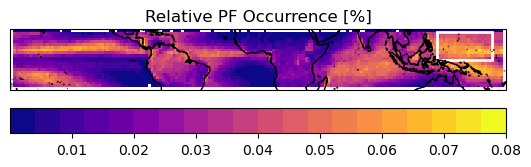

In [37]:
num_pfs = binned_statistic_2d(
        pf_stats['mean_latitude'], 
        pf_stats['mean_longitude'],
        None, 
        bins=[lat_bins, lon_bins],
        statistic='count'
).statistic
frac_pfs = 100*num_pfs/num_pfs.sum()
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, frac_pfs, cmap='plasma', norm=colors.Normalize(vmin=1e-10,vmax=0.8e-1), title=f'Relative PF Occurrence [%]')

# Add box showing gSAM domain
rect = mpatches.Rectangle(
(130, 0),  # (lon_min, lat_min)
40,        # width in degrees
20,        # height in degrees
linewidth=2,
edgecolor='white',
facecolor='none',
transform=ccrs.PlateCarree()
)
ax.add_patch(rect)
save_figure(fig, 'Map PF ROF map')

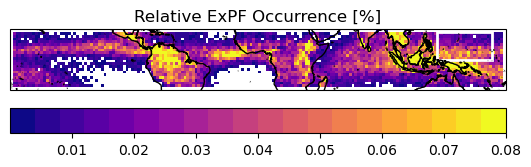

In [43]:
num_ex_pfs = binned_statistic_2d(
    expf_stats['mean_latitude'], 
    expf_stats['mean_longitude'],
    None, 
    bins=[lat_bins, lon_bins],
    statistic='count'
).statistic

frac_pfs = 100*num_ex_pfs/num_ex_pfs.sum()
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, frac_pfs, cmap='plasma', norm=colors.Normalize(vmin=1e-10,vmax=0.8e-1), title=f'Relative ExPF Occurrence [%]')

# Add box showing gSAM domain
rect = mpatches.Rectangle(
(130, 0),  # (lon_min, lat_min)
40,        # width in degrees
20,        # height in degrees
linewidth=2,
edgecolor='white',
facecolor='none',
transform=ccrs.PlateCarree()
)
ax.add_patch(rect)
save_figure(fig, 'Map ExPF ROF map')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_54995/913449646.py:18: RuntimeWarning: invalid value encountered in divide
  cond_prob = 100*num_ex_pfs/num_pfs


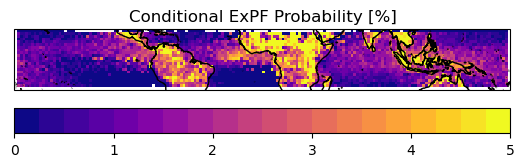

In [38]:
num_ex_pfs = binned_statistic_2d(
    expf_stats['mean_latitude'], 
    expf_stats['mean_longitude'],
    None, 
    bins=[lat_bins, lon_bins],
    statistic='count'
).statistic

num_pfs = binned_statistic_2d(
        pf_stats['mean_latitude'], 
        pf_stats['mean_longitude'],
        None, 
        bins=[lat_bins, lon_bins],
        statistic='count'
).statistic

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
cond_prob = 100*num_ex_pfs/num_pfs
_plot(ax, cond_prob, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=5), title='Conditional ExPF Probability [%]')
save_figure(fig, 'Map Conditional ExPF Probability')

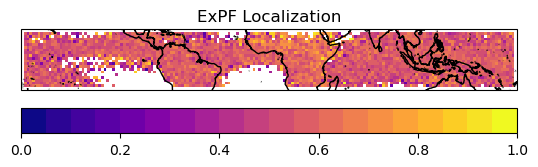

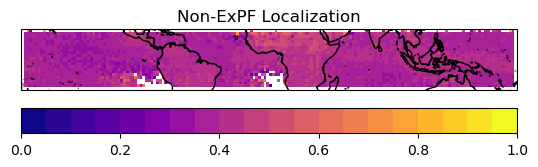

In [39]:
expf_loc = binned_statistic_2d(
    expf_stats['mean_latitude'], 
    expf_stats['mean_longitude'],
    expf_stats['largest_10mmhr_cluster_rain']/expf_stats['total_precip'], 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, expf_loc, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=1), title=f'ExPF Localization')
save_figure(fig, 'Map ExPF Loc')

nexpf_loc = binned_statistic_2d(
    nonexpf_stats['mean_latitude'], 
    nonexpf_stats['mean_longitude'],
    nonexpf_stats['largest_10mmhr_cluster_rain']/nonexpf_stats['total_precip'], 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, nexpf_loc, cmap='plasma', norm=colors.Normalize(vmin=0,vmax=1), title=f'Non-ExPF Localization')
save_figure(fig, 'Map NonExPF Loc')

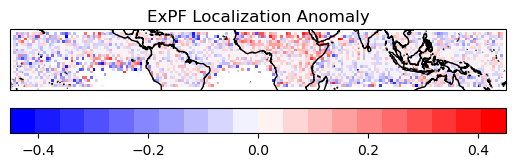

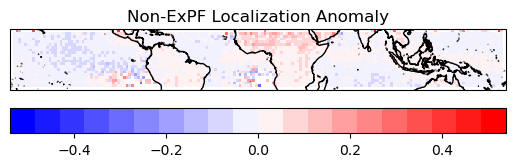

In [44]:
# ExPF
expf_loc = binned_statistic_2d(
    expf_stats['mean_latitude'],
    expf_stats['mean_longitude'],
    expf_stats['largest_10mmhr_cluster_rain'] / expf_stats['total_precip'],
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic
expf_loc_anom = expf_loc - np.nanmean(expf_loc)
vlim = np.nanmax(np.abs(expf_loc_anom))

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(
    ax,
    expf_loc_anom,
    cmap='bwr',
    norm=colors.TwoSlopeNorm(vmin=-vlim, vcenter=0, vmax=vlim),
    title='ExPF Localization Anomaly'
)

# Non-ExPF
nexpf_loc = binned_statistic_2d(
    nonexpf_stats['mean_latitude'],
    nonexpf_stats['mean_longitude'],
    nonexpf_stats['largest_10mmhr_cluster_rain'] / nonexpf_stats['total_precip'],
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic
nexpf_loc_anom = nexpf_loc - np.nanmean(nexpf_loc)
vlim = np.nanmax(np.abs(nexpf_loc_anom))

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(
    ax,
    nexpf_loc_anom,
    cmap='bwr',
    norm=colors.TwoSlopeNorm(vmin=-vlim, vcenter=0, vmax=vlim),
    title='Non-ExPF Localization Anomaly'
)

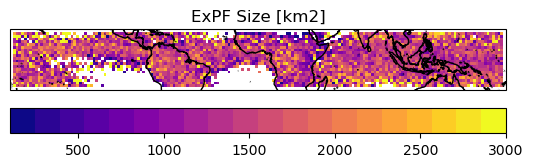

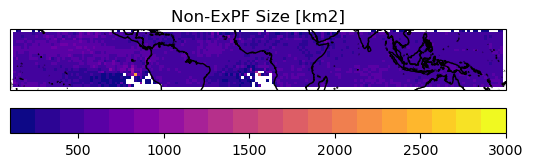

In [40]:
expf_size = binned_statistic_2d(
    expf_stats['mean_latitude'], 
    expf_stats['mean_longitude'],
    expf_stats['num_pixels']*25, 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, expf_size, cmap='plasma', norm=colors.Normalize(vmin=1e2,vmax=3e3), title=f'ExPF Size [km2]')
save_figure(fig, 'Map ExPF Size')

nexpf_size = binned_statistic_2d(
    nonexpf_stats['mean_latitude'], 
    nonexpf_stats['mean_longitude'],
    nonexpf_stats['num_pixels']*25, 
    bins=[lat_bins, lon_bins],
    statistic=np.nanmean
).statistic

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
_plot(ax, nexpf_size, cmap='plasma', norm=colors.Normalize(vmin=1e2,vmax=3e3), title=f'Non-ExPF Size [km2]')
save_figure(fig, 'Map NonExPF Size')